# Data Challenge 2
## Daniel Hannah (dan@danhannah.site), Insight Data Science

I will start by reading in the data from the CSV files provided and having a look at the data.

In [99]:
# Some needed imports
from pygeocoder import Geocoder
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# Global settings to make plots more legible.
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['font.sans-serif'] = 'DejaVu Sans'

In [285]:
# Read in the raw data and join the two.
test_results = pd.DataFrame.from_csv("test_results.csv")
user_table = pd.DataFrame.from_csv("user_table.csv")
d_f = test_results.join(user_table)

In [288]:
d_f.head()  # Visualize the structure of the DataFrame.

,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
user_id,,,,,,,,,,,
604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


The most basic way to answer the question of "How much should we sell our software for?" is to simply consider which selling scheme added more revenue considering the percentage of users who bought the product. The first thing we need to do establish that significantly fewer users bought the higher-priced product - if the product priced can be raised _without_ lowering the number of people buying it, then it's clearly a good call for the company.

We can examine this by creating a control and test group, then looking at whether the means of their "converted" columns differ.  Note that the mean of a binary 0/1 column is equivalent to looking at the percentage of uesrs who converted from that group, because it boils down to:

\begin{equation}
\frac{N_{\rm users}^{\rm converted}}{N_{\rm users}^{\rm total}}
\end{equation}

In [266]:
# Getting separate data frames for the control and test groups.
control_d_f = d_f[d_f["test"] == 0]
test_d_f = d_f[d_f["test"] == 1]

Now there are two important questions:

1. Does the fraction of converted users differ between groups?
2. If so, is the difference significant?

Because we are drawing our samples from a distribution of binary outcomes, a $\chi^2$ test is the appropriate way to determine if the observed differences are significant:

In [267]:
print("Percentage of conversions in control group: " + str(100*control_d_f["converted"].mean()))
print("Percentage of conversions in control group: " + str(100*test_d_f["converted"].mean()))

# Build a contigency table for chi^2 testing.
unconverted_test = len(test_d_f[test_d_f["converted"] == 0])
converted_test = len(test_d_f[test_d_f["converted"] == 1])
unconverted_control = len(control_d_f[control_d_f["converted"] == 0])
converted_control = len(control_d_f[control_d_f["converted"] == 1])
c_t = [[converted_test, unconverted_test], [converted_control, unconverted_control]]

# Perform a chi^2 test and check if the p-value indicates significance.
chi2, p = stats.chi2_contingency(c_t)[:2]
print("Chi^2 = {}, p = {}".format(chi2, p))

Percentage of conversions in control group: 1.99036142201
Percentage of conversions in control group: 1.55426788109
Chi^2 = 76.89494424182652, p = 1.8029808465845306e-18


It would appear that the price jump was enough to deter a statistically significant percentage of users from buying the product ($p \propto 10^{-18}$). Does the smaller number of conversions justify the increased revenue per conversion?

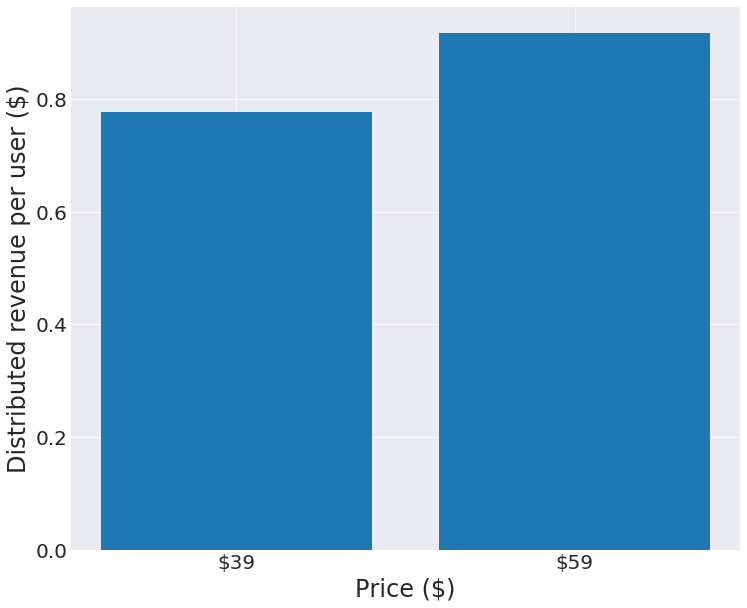

In [268]:
frac_control_conv = control_d_f["converted"].mean()  # Proportion of $39 conversions.
frac_test_conv = test_d_f["converted"].mean()  # Proportion of $59 conversions.

sns.set_style("darkgrid")
plt.bar(["$39", "$59"], [frac_control_conv * 39, frac_test_conv * 59])
plt.xlabel("Price ($)")
plt.ylabel("Distributed revenue per user ($)")
plt.show()

Considering the entire market simultaneously, the drop in conversion rate is more than offset by the increased revenue per user and that the **company should sell its product for \$59**. Before moving too far ahead with this conclusion, let's make sure the test and control groups appear to be similar.

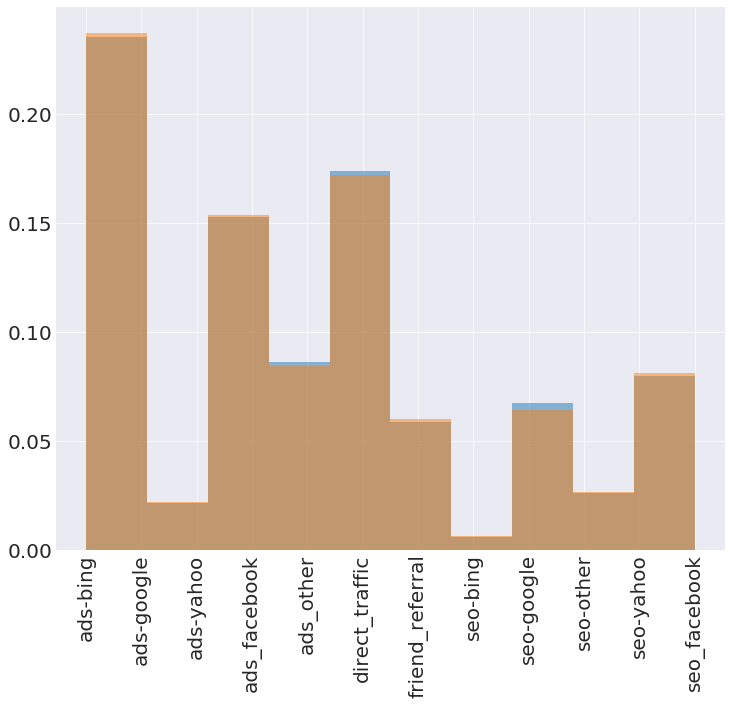

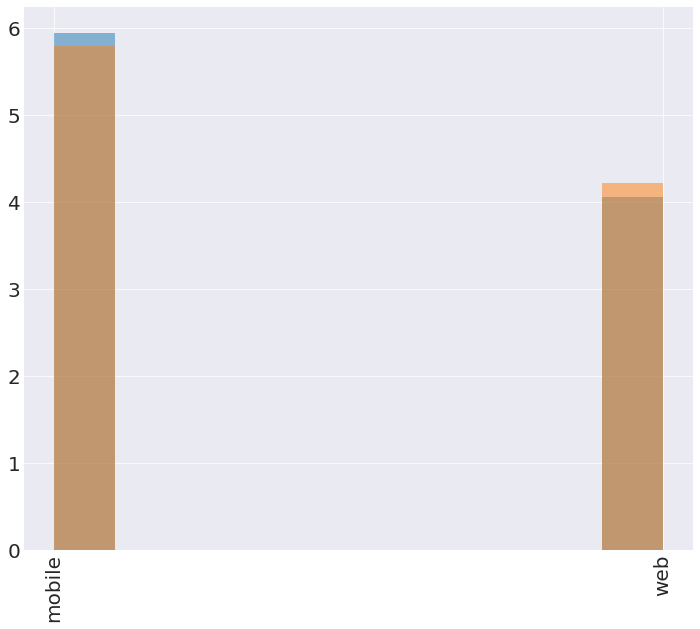

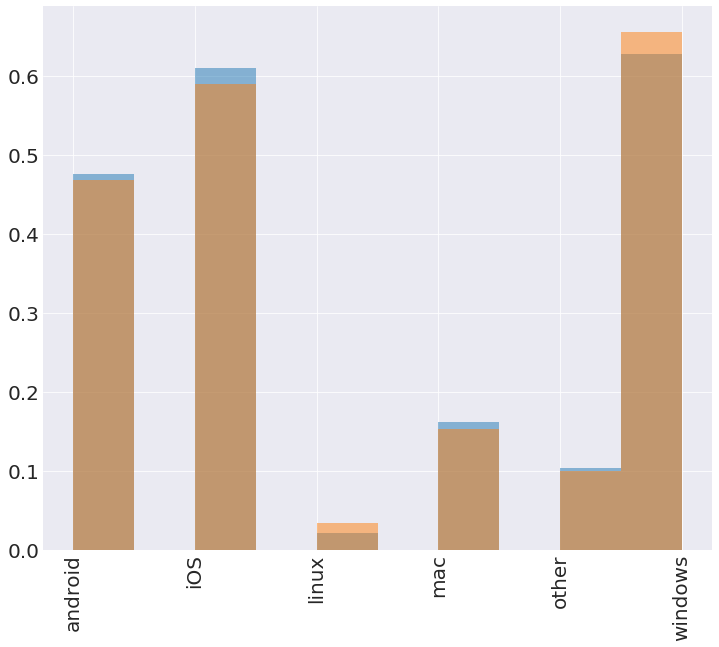

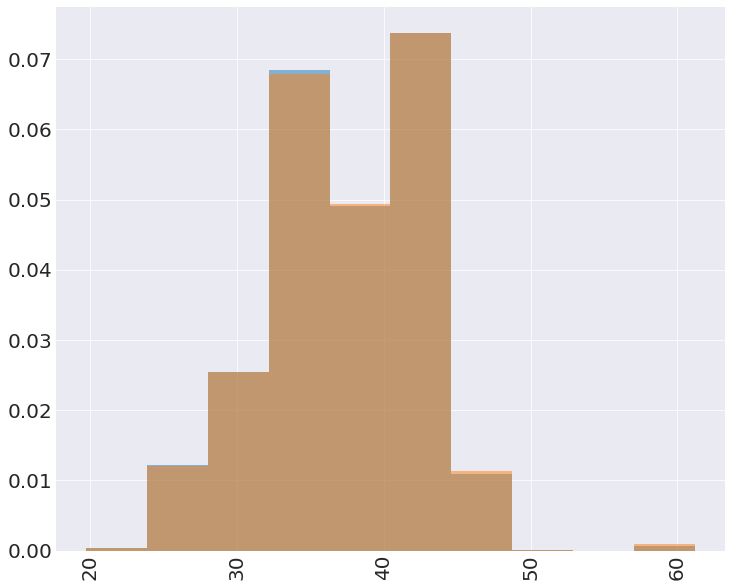

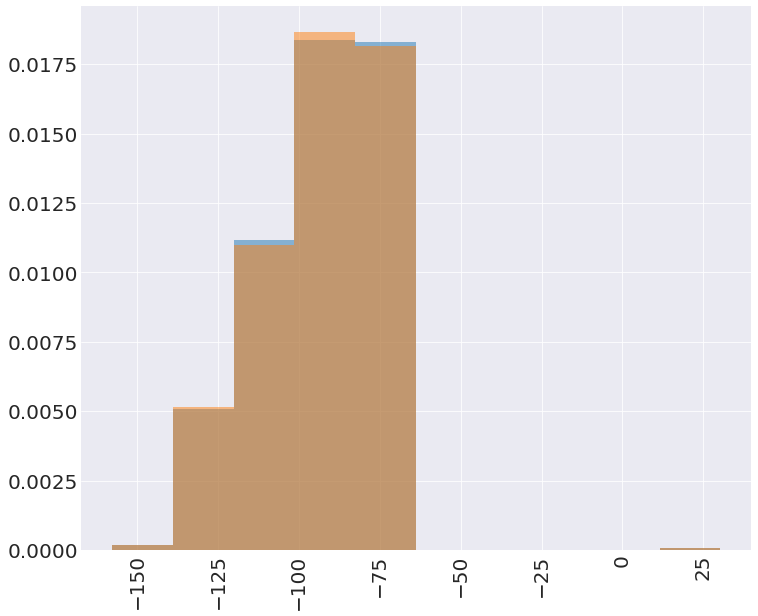

In [269]:
plt.gcf().clear()
cols = ["source", "device", "operative_system", "lat", "long"]
for col in cols:
    control_d_f[col].hist(normed=1, alpha=0.5)
    test_d_f[col].hist(normed=1, alpha=0.5)
    plt.xticks(rotation="vertical")
    plt.show()

The distributions in the control and test groups appear similar, indicating that demographics aren't being over/under-represented in the test or control groups.  Let's see which factors are most important in determining whether a person buys the software at a higher price.

In [270]:
# Need one-hot encoding for categorical variables
control_onehot = pd.get_dummies(data=control_d_f, columns=["source", "device", "operative_system"])
test_onehot = pd.get_dummies(data=test_d_f, columns=["source", "device", "operative_system"])

In [271]:
from sklearn import tree
control_clf = tree.DecisionTreeClassifier()
test_clf = tree.DecisionTreeClassifier()
control_clf = control_clf.fit(control_onehot[list(control_onehot)[8:]], control_onehot["converted"])
test_clf = test_clf.fit(test_onehot[list(test_onehot)[8:]], test_onehot["converted"])

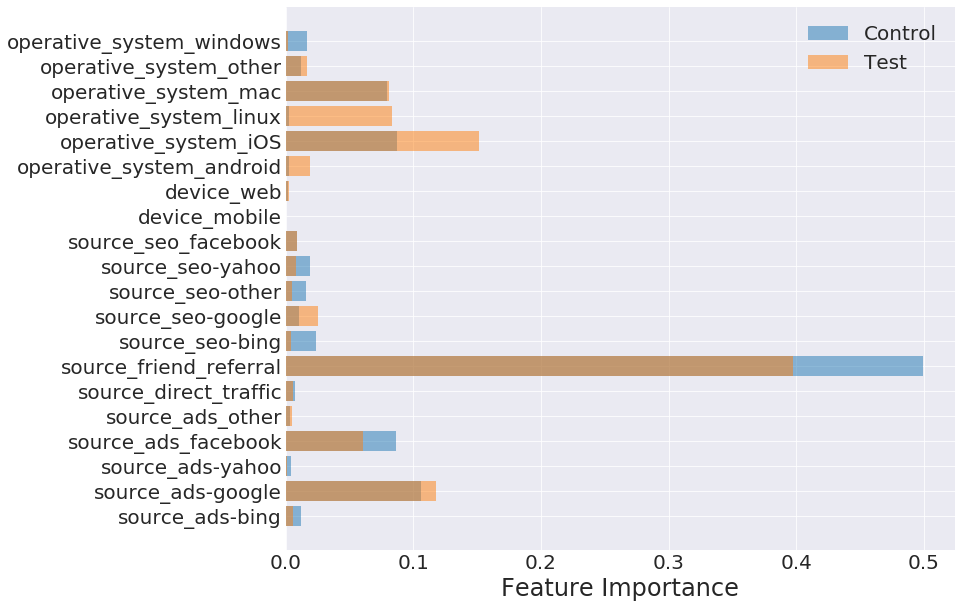

In [272]:
control_feature_labels = []
control_feature_importances = []
for name, importance in zip(list(control_onehot)[8:], control_clf.feature_importances_):
    control_feature_labels.append(name)
    control_feature_importances.append(importance)
test_feature_labels = []
test_feature_importances = []
for name, importance in zip(list(test_onehot)[8:], test_clf.feature_importances_):
    test_feature_labels.append(name)
    test_feature_importances.append(importance)
plt.barh(range(len(control_feature_importances)), control_feature_importances, alpha=0.5, label="Control")
plt.barh(range(len(test_feature_importances)), test_feature_importances, alpha=0.5, label="Test")
plt.yticks(range(len(control_feature_importances)), control_feature_labels)
plt.legend(fontsize=20)
plt.xlabel("Feature Importance")
plt.show()

In both the test and control grops, friend referral is by far the most important factor in determining a conversion. Ads on Facebook and Google appear to have some effect in both cases as well. The operating system of a user clearly matters, with Linux users seeming to have much more of a distinction in the high-priced group.

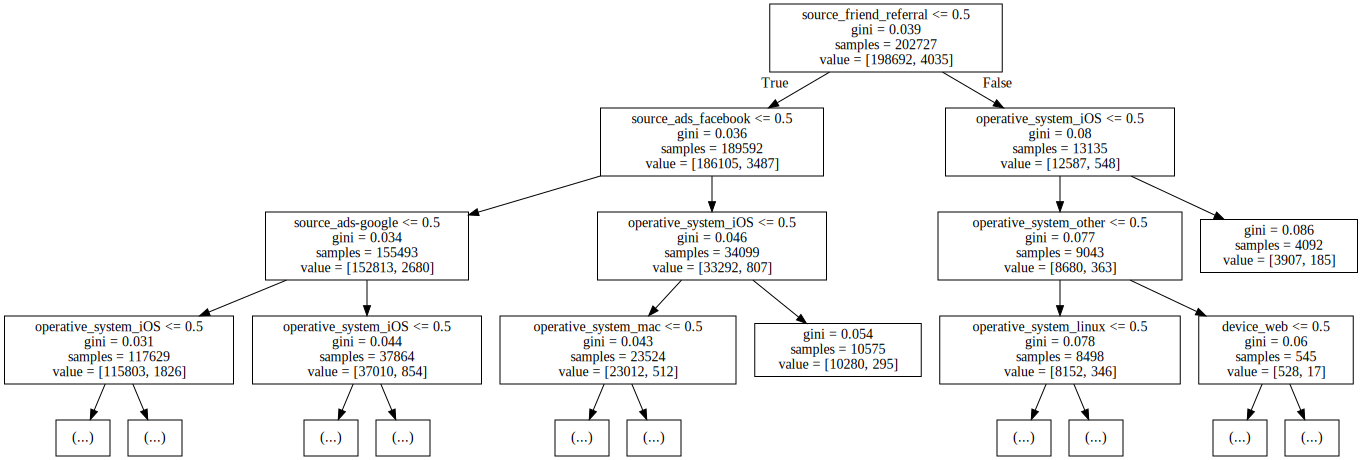

In [273]:
import graphviz
dot_data = tree.export_graphviz(control_clf, out_file=None, max_depth=3, feature_names=control_feature_labels)
graph = graphviz.Source(dot_data)
graph

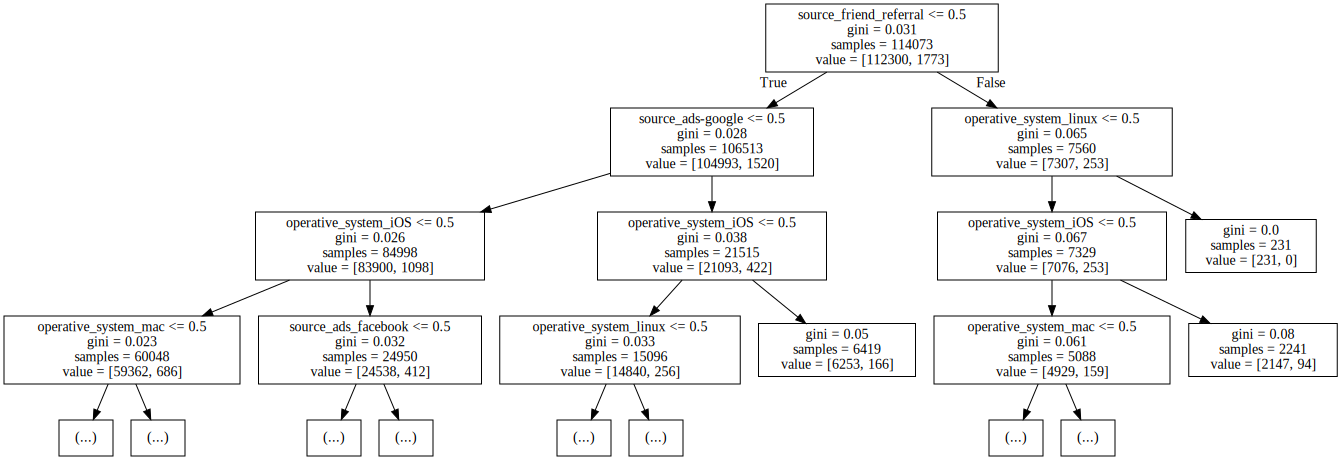

In [274]:
tdot_data = tree.export_graphviz(test_clf, out_file=None, max_depth=3, feature_names=test_feature_labels)
graph = graphviz.Source(tdot_data)
graph

In [275]:
# Checking if referral increases are statistically significant:
test_group_friend_ref = [[1773, 112300], [253, 7307]]
control_group_friend_ref = [[4035, 198692], [548, 12587]]

# Chi^2 testing
chi2, p = stats.chi2_contingency(test_group_friend_ref)[:2]
print("Chi^2 = {}, p = {}".format(chi2, p))
chi2, p = stats.chi2_contingency(control_group_friend_ref)[:2]
print("Chi^2 = {}, p = {}".format(chi2, p))

# Checking if ad increases are statistically significant:
test_group_ads = [[1520, 104993], [422, 21093]]
control_group_ads = [[3487, 186105], [807, 33292]]

chi2, p = stats.chi2_contingency(test_group_ads)[:2]
print("Chi^2 = {}, p = {}".format(chi2, p))
chi2, p = stats.chi2_contingency(control_group_ads)[:2]
print("Chi^2 = {}, p = {}".format(chi2, p))

Chi^2 = 137.96016060164345, p = 7.435361938959231e-32
Chi^2 = 281.5047471179281, p = 3.5293014505839334e-63
Chi^2 = 33.85779758150956, p = 5.929097765310019e-09
Chi^2 = 42.42151785134576, p = 7.357609709219823e-11


## Findings from decision tree

1. When users are referred by friends, the conversion rate increases by 3% in the control group and 2% in the test group.  These increases are **statistically significant**.

2. Ads also result in a statistically significant increase in user retention among users not referred by friend, although this increase is smaller. However, ads are a much easier externality to control than friend referral.

The ability of ads to increase conversion begs the question of whether the investment in ads is worth it. Below, I examine the ad cost at which increased conversions are no longer beneficial.

0.019614222635370673
0.014270558523372733


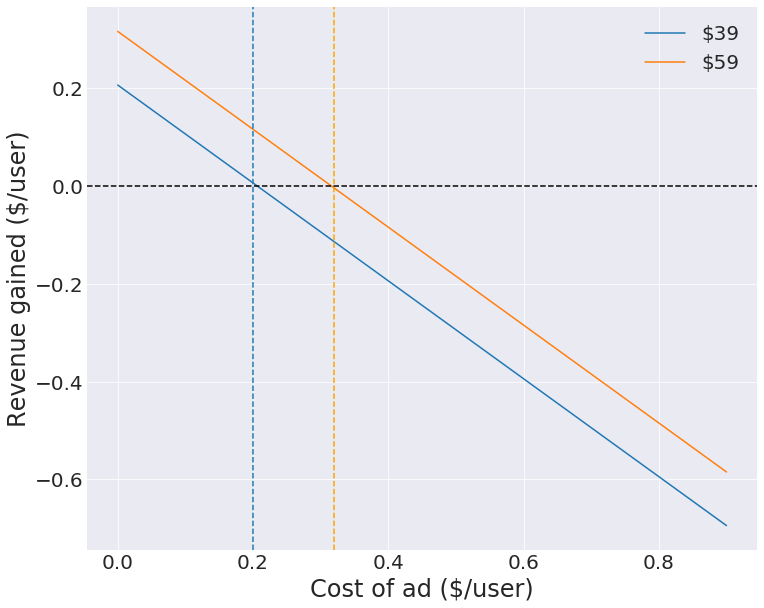

In [276]:
test_group_increase = (422 / (21093 + 422)) - (1520 / (1520 + 104993))
control_group_increase = (807 / (807 + 33292)) - (3487 / (186105 + 3487))

print((422 / (21093 + 422)))
print((1520 / (1520 + 104993)))

ad_cost = np.arange(0, 1, 0.1)
plt.plot(ad_cost, 39*control_group_increase - ad_cost, label="$39")
plt.plot(ad_cost, 59*test_group_increase - ad_cost, label="$59")
plt.axvline(x=0.20, linestyle='dashed')
plt.axvline(x=0.32, linestyle='dashed', color='orange')
plt.axhline(y=0, linestyle='dashed', color='black')
plt.legend(fontsize=20)
plt.xlabel("Cost of ad ($/user)")
plt.ylabel("Revenue gained ($/user)")
plt.show()

Generally, ads are worth investing in if:

1. The cost of the product is \$59 and the cost of an ad is less than 35 cents per user view.
2. The cost of the product is \$39 and the cost of an ad is less than 20 cents per user view.

Although I do not explore this distinction in-depth at present, it is worth noting that Facebook ads are more effective at improving retention in the control group, while Google ads are more effective at improiving retention in the test group.  Next, I'll look at how users are geographically distributed.

In [277]:
totals = d_f['city'].value_counts()
print(totals)

New York                    25748
Chicago                      7153
Houston                      6706
San Antonio                  4633
Los Angeles                  4141
San Jose                     3354
Indianapolis                 3217
Jacksonville                 2905
Philadelphia                 2541
Las Vegas                    2426
Austin                       2292
Seattle                      2204
Oklahoma City                1796
Charlotte                    1768
Tucson                       1732
Virginia Beach               1712
Oakland                      1686
Nashville                    1581
Mesa                         1557
Memphis                      1540
Minneapolis                  1466
Fort Worth                   1429
Buffalo                      1303
Raleigh                      1293
New Orleans                  1263
Springfield                  1246
Tampa                        1217
Dallas                       1207
Detroit                      1178
Plano         

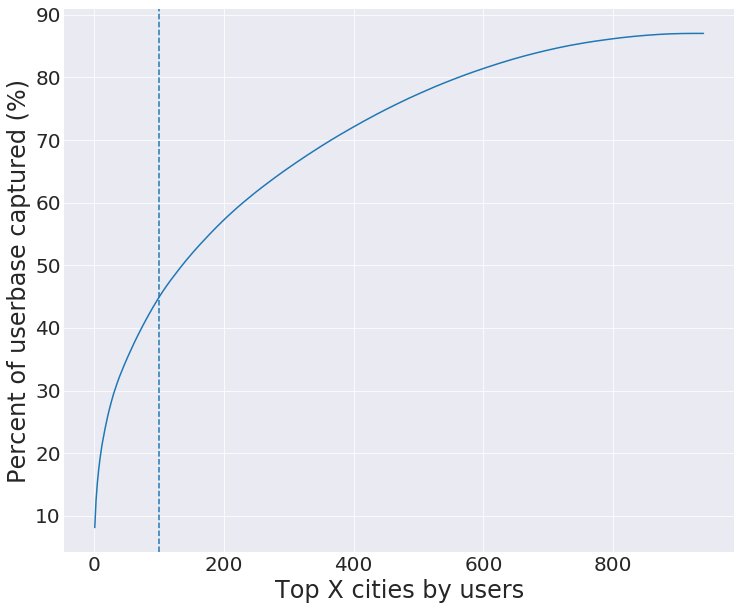

In [217]:
percent_captured = totals/len(d_f) * 100
indices = range(1, 940)
total_captured = [sum(percent_captured[:i]) for i in indices]
plt.plot(indices, total_captured)
plt.axvline(x=100, linestyle='dashed')
plt.xlabel("Top X cities by users")
plt.ylabel("Percent of userbase captured (%)")
plt.show()

New York is by far the largest city for the userbase, with Chicago and Houston being a distant second and third, respectively. Although we do not have information about how ads (particularly internet ads) and friend referral efforts scale with local cost, it suggests that targeting the New York area is an effective strategy for increasing revenue in the event that advertising/referral incentives exhibit any economy of scale. In particular, the top 100 cities (out of 946) account for ~45% of the userbase. Finally, we will examine if the test could have been stopped earlier.

In [238]:
# Statistics for a power analysis.

p = (frac_control_conv + frac_test_conv) / 2
Z8 = stats.norm.ppf(.8) # we will need this to ensure 80% power (20% false negative rate)
Z95 = stats.norm.ppf(1 - .05) # we will need this for 5% false positive rate (95% confidence level), one-tailed
ES = abs(p_b - p_a)/np.sqrt(p*(1-p))
n = round(2*((Z95 + Z8)/ES)**2 )  # Number of samples needed for 5% FP, 20% FN

In [362]:
# Build a time series to track the number of users accumulated per day.
dates = pd.to_datetime(test_d_f["timestamp"], errors='coerce')
test_d_f["timestamp"] = dates
test_d_f["date"] = test_d_f["timestamp"].dt.date
days = list(test_d_f["date"].values)
counts = list(test_d_f.groupby(["date"]).count()["timestamp"].values)

day_data = []
count_data = []
for idx, day in enumerate(counts):
    day_data.append(idx)
    count_data.append(sum(counts[:idx]))

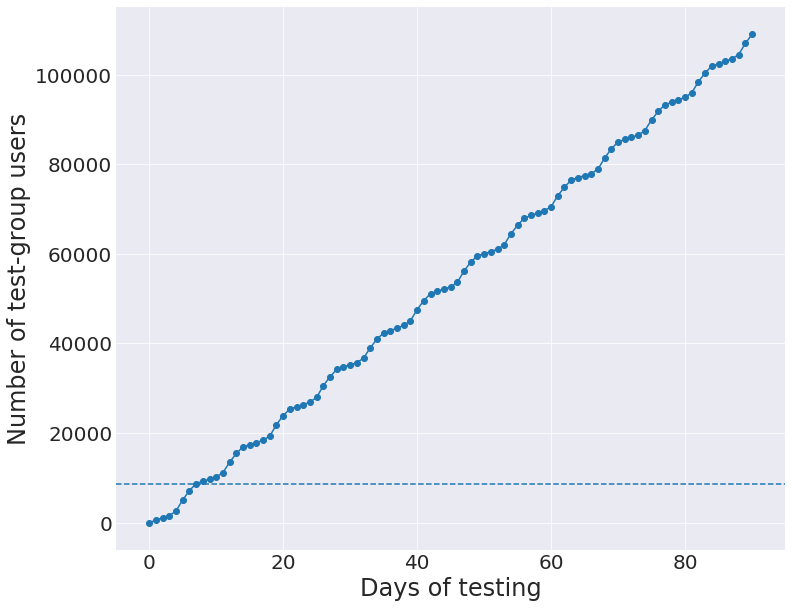

In [364]:
plt.plot(day_data, count_data)
plt.scatter(day_data, count_data)
plt.xlabel("Days of testing")
plt.ylabel("Number of test-group users")
plt.axhline(y=n, linestyle='dashed')
plt.show()

## Conclusions

* The software should be sold for \$59 - while a smaller number of users purchase the software at this price point, the increased revenue ends up offsetting the cost.

* There are some opportunities for optimization:
    - Friend referral increases the likelihood of conversion by roughly 3%, anything which can be done to improve this is high-yield.
    - Ads on Google (for the test group) and Facebook (for the control group) also increased conversion, and if ads can be obtained at a cost of 35 cents per user view or less, they are likely a good investment. Similarly, Linux users are unlikely to buy the software at a higher price and may not be good ad candidates, especially given that there are so few of them to begin with.
    - Targeting iOS and macOS users is likely to yield higher dividends than other groups; these users bought the pricier software in high proportions.
    - If ads must be localized, New York and Chicago represent a huge fraction of the userbase and should be key focus areas.

* Using a 20% false negative rate and a 5% false positive rate, the study could have been stopped a mere 10 days in to running. Certainly a month would have been more than enough to detect even more subtle changes in user conversion rate.